# NoETL Playbook Execution Report
__Agent 007 mission report:__ _Operation completed. Martini status: shaken, not stirred._
- This notebook provides a report of the execution of a NoETL playbook using the `agent007.py` script.
- It analyzes the DuckDB database generated during the playbook run, with execution flow, step results, loop iterations, task executions, and context data captured throughout the process.
1. Run playbook with `agent007.py`.
2. Set `db_path` below to that file path.
3. Run all paragraphs to inspect tables and data.


## Set the database path and list all tables


In [56]:
import duckdb
import polars as pl
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
import networkx as nx
from datetime import datetime

# Path to DuckDB database
db_path = '../data/noetldb/agent007.duckdb'  # Default path used by agent007.py
# Example: db_path = '/Users/kadyapam/projects/noetl/noetl/noetl/runtime/agent007.duckdb'

if not os.path.exists(db_path) and db_path != ':memory:':
    raise FileNotFoundError(f"DuckDB database not found: {db_path}")

con = duckdb.connect(db_path)

def parse_json_column(df, column_name):
    if column_name in df.columns:
        def safe_json_parse(x):
            if not x:
                return None
            try:
                return json.loads(x)
            except json.JSONDecodeError as e:
                print(f"Warning: Could not parse JSON: {e}")
                return x

        return df.with_columns([
            pl.col(column_name).map_elements(safe_json_parse, return_dtype=pl.Object)
        ])
    return df

latest_execution = con.execute("""
    SELECT execution_id, MAX(timestamp) as latest_time
    FROM event_log
    GROUP BY execution_id
    ORDER BY latest_time DESC
    LIMIT 1
""").fetchone()

if latest_execution:
    execution_id = latest_execution[0]
    print(f"Analyzing execution ID: {execution_id}")
else:
    print("No executions found in the database.")
    execution_id = None


Analyzing execution ID: e1fe532e-5719-4fae-b4fe-afea46c06d29


In [57]:
tables = con.execute("SHOW TABLES").fetchall()
for t in tables:
    print(t[0])


context
event_log
loop_state
step_result
task_result
transition
workbook
workflow


## Execution Overview

Overview of the playbook execution.


In [58]:
if execution_id:
    execution_times = con.execute("""
        SELECT 
            MIN(timestamp) as start_time,
            MAX(timestamp) as end_time,
            (EXTRACT(EPOCH FROM MAX(timestamp)) - EXTRACT(EPOCH FROM MIN(timestamp))) as duration_seconds
        FROM event_log
        WHERE execution_id = ?
    """, [execution_id]).fetchone()

    execution_stats = con.execute("""
        SELECT
            (SELECT COUNT(*) FROM step_result WHERE execution_id = ?) as step_count,
            (SELECT COUNT(*) FROM event_log WHERE execution_id = ? AND event_type LIKE 'task_%') as task_count,
            (SELECT COUNT(*) FROM loop_state WHERE execution_id = ?) as loop_count,
            (SELECT COUNT(*) FROM event_log WHERE execution_id = ? AND event_type LIKE '%error%') as error_count
    """, [execution_id, execution_id, execution_id, execution_id]).fetchone()

    playbook_info = con.execute("""
        SELECT node_name, metadata
        FROM event_log
        WHERE execution_id = ? AND event_type = 'execution_start'
        LIMIT 1
    """, [execution_id]).fetchone()

    print(f"Playbook: {playbook_info[0] if playbook_info else 'Unknown'}")
    print(f"Start Time: {execution_times[0]}")
    print(f"End Time: {execution_times[1]}")
    print(f"Duration: {execution_times[2]:.2f} seconds")
    print(f"Steps Executed: {execution_stats[0]}")
    print(f"Tasks Executed: {execution_stats[1]}")
    print(f"Loops Executed: {execution_stats[2]}")
    print(f"Errors Encountered: {execution_stats[3]}")

    if playbook_info and playbook_info[1]:
        try:
            metadata = json.loads(playbook_info[1])
            print("\nPlaybook Metadata:")
            for key, value in metadata.items():
                print(f"  {key}: {value}")
        except:
            pass
else:
    print("No execution ID available.")


Playbook: weather_example
Start Time: 2025-06-18 06:42:22.774743
End Time: 2025-06-18 06:42:25.170777
Duration: 2.40 seconds
Steps Executed: 3
Tasks Executed: 6
Loops Executed: 1
Errors Encountered: 0

Playbook Metadata:
  playbook_path: ./catalog/playbooks/weather_example.yaml


## Step Execution Analysis

Analyze the execution of steps in the playbook.


In [59]:
if execution_id:
    step_results = pl.from_arrow(con.execute("""
        SELECT 
            step_id, 
            step_name, 
            parent_id, 
            timestamp, 
            status, 
            data, 
            error
        FROM step_result
        WHERE execution_id = ?
        ORDER BY timestamp
    """, [execution_id]).arrow())

    step_results = parse_json_column(step_results, 'data')

    step_summary = pl.from_arrow(con.execute("""
        SELECT 
            step_name, 
            COUNT(*) as execution_count,
            COUNT(CASE WHEN status = 'success' THEN 1 END) as success_count,
            COUNT(CASE WHEN status = 'error' THEN 1 END) as error_count
        FROM step_result
        WHERE execution_id = ?
        GROUP BY step_name
        ORDER BY execution_count DESC
    """, [execution_id]).arrow())

    print("Step Execution Summary:")
    display(step_summary)
    print("\nStep Results:")
    display(step_results)
else:
    print("No execution ID available.")


Step Execution Summary:


step_name,execution_count,success_count,error_count
str,i64,i64,i64
"""city_loop""",1,1,0
"""end_city_loop""",1,1,0
"""start""",1,1,0



Step Results:


step_id,step_name,parent_id,timestamp,status,data,error
str,str,str,datetime[μs],str,object,str
"""057dfb2d-fdf0-4f98-9a89-89b1ef…","""start""",null,2025-06-18 06:42:22.776563,"""success""",{},null
"""b5e28afb-5588-425b-a973-acda2f…","""city_loop""",null,2025-06-18 06:42:24.992813,"""success""","[{'fetch_and_evaluate': {'city': 'London', 'max_temp': 27.7, 'alert': True}}, {'fetch_and_evaluate': {'city': 'Paris', 'max_temp': 29.0, 'alert': True}}, {'fetch_and_evaluate': {'city': 'Berlin', 'max_temp': 26.8, 'alert': True}}]",null
"""d403e6ca-ba5d-4c88-b71d-f3f4ae…","""end_city_loop""","""fb6f2120-d170-4d5a-9633-158177…",2025-06-18 06:42:25.016267,"""success""","{'alerts': ""[{'city': 'London', 'max_temp': 27.7, 'alert': True}, {'city': 'Paris', 'max_temp': 29.0, 'alert': True}, {'city': 'Berlin', 'max_temp': 26.8, 'alert': True}]""}",null


## Loop Execution Analysis

Analyze the execution of loops in the playbook.


In [60]:
if execution_id:
    loop_state = pl.from_arrow(con.execute("""
        SELECT 
            loop_id, 
            loop_name, 
            parent_id, 
            iterator, 
            items, 
            current_index, 
            current_item, 
            results, 
            timestamp, 
            status
        FROM loop_state
        WHERE execution_id = ?
        ORDER BY timestamp
    """, [execution_id]).arrow())

    loop_state = parse_json_column(loop_state, 'items')
    loop_state = parse_json_column(loop_state, 'current_item')
    loop_state = parse_json_column(loop_state, 'results')

    if len(loop_state) > 0:
        print("Loop Execution Summary:")
        display(loop_state)

        loop_events = pl.from_arrow(con.execute("""
            SELECT 
                event_id, 
                node_name, 
                event_type, 
                timestamp, 
                status, 
                duration, 
                output_result as data, 
                metadata
            FROM event_log
            WHERE execution_id = ? AND event_type LIKE '%loop%'
            ORDER BY timestamp
        """, [execution_id]).arrow())

        loop_events = parse_json_column(loop_events, 'data')
        loop_events = parse_json_column(loop_events, 'metadata')

        print("\nLoop Events:")
        display(loop_events)
    else:
        print("No loop executions found.")
else:
    print("No execution ID available.")


Loop Execution Summary:


loop_id,loop_name,parent_id,iterator,items,current_index,current_item,results,timestamp,status
str,str,str,str,object,i32,object,object,datetime[μs],str
"""fb6f2120-d170-4d5a-9633-158177…","""city_loop""","""b5e28afb-5588-425b-a973-acda2f…","""city""","[{'name': 'London', 'lat': 51.51, 'lon': -0.13}, {'name': 'Paris', 'lat': 48.85, 'lon': 2.35}, {'name': 'Berlin', 'lat': 52.52, 'lon': 13.41}]",3,null,"[{'fetch_and_evaluate': {'city': 'London', 'max_temp': 27.7, 'alert': True}}, {'fetch_and_evaluate': {'city': 'Paris', 'max_temp': 29.0, 'alert': True}}, {'fetch_and_evaluate': {'city': 'Berlin', 'max_temp': 26.8, 'alert': True}}]",2025-06-18 06:42:25.015816,"""completed"""



Loop Events:


event_id,node_name,event_type,timestamp,status,duration,data,metadata
str,str,str,datetime[μs],str,f64,object,object
"""c3a9e66e-ca5e-43bf-ac80-ed3fb5…","""city_loop""","""loop_start""",2025-06-18 06:42:22.781836,"""in_progress""",0.0,null,"{'item_count': 3, 'iterator': 'city'}"
"""b6d2ff2f-2743-4ddf-a860-d4955e…","""city_loop[0]""","""loop_iteration""",2025-06-18 06:42:22.787156,"""in_progress""",0.0,null,"{'index': 0, 'item': {'name': 'London', 'lat': 51.51, 'lon': -0.13}}"
"""d6877cef-2216-42e5-8894-ec8119…","""city_loop[0]""","""loop_iteration_complete""",2025-06-18 06:42:23.592357,"""success""",0.0,"{'fetch_and_evaluate': {'city': 'London', 'max_temp': 27.7, 'alert': True}}","{'index': 0, 'item': {'name': 'London', 'lat': 51.51, 'lon': -0.13}}"
"""05a4a129-7764-4855-8564-86e90b…","""city_loop[1]""","""loop_iteration""",2025-06-18 06:42:23.594308,"""in_progress""",0.0,null,"{'index': 1, 'item': {'name': 'Paris', 'lat': 48.85, 'lon': 2.35}}"
"""f64e13da-53b2-4e06-a3a5-dcdf4d…","""city_loop[1]""","""loop_iteration_complete""",2025-06-18 06:42:24.286826,"""success""",0.0,"{'fetch_and_evaluate': {'city': 'Paris', 'max_temp': 29.0, 'alert': True}}","{'index': 1, 'item': {'name': 'Paris', 'lat': 48.85, 'lon': 2.35}}"
"""a9457a91-d2f5-4c70-ac3b-bb5fca…","""city_loop[2]""","""loop_iteration""",2025-06-18 06:42:24.288024,"""in_progress""",0.0,null,"{'index': 2, 'item': {'name': 'Berlin', 'lat': 52.52, 'lon': 13.41}}"
"""6420d506-8273-44e7-9868-d2226a…","""city_loop[2]""","""loop_iteration_complete""",2025-06-18 06:42:24.991070,"""success""",0.0,"{'fetch_and_evaluate': {'city': 'Berlin', 'max_temp': 26.8, 'alert': True}}","{'index': 2, 'item': {'name': 'Berlin', 'lat': 52.52, 'lon': 13.41}}"
"""66f4ee66-6468-4675-8569-292636…","""city_loop""","""loop_complete""",2025-06-18 06:42:24.994020,"""success""",2.212694,"[{'fetch_and_evaluate': {'city': 'London', 'max_temp': 27.7, 'alert': True}}, {'fetch_and_evaluate': {'city': 'Paris', 'max_temp': 29.0, 'alert': True}}, {'fetch_and_evaluate': {'city': 'Berlin', 'max_temp': 26.8, 'alert': True}}]","{'item_count': 3, 'processed_count': 3}"
"""3a58bbbf-bbb1-44cd-8830-2d0385…","""end_city_loop""","""end_loop_start""",2025-06-18 06:42:25.001039,"""in_progress""",0.0,null,{'loop_name': 'city_loop'}


## Task Execution Analysis

Analyze the execution of tasks in the playbook.


In [61]:
if execution_id:
    task_results = pl.from_arrow(con.execute("""
        SELECT 
            node_id as task_id, 
            node_name as task_name, 
            node_type as task_type, 
            parent_event_id as parent_id, 
            timestamp, 
            status, 
            output_result as data, 
            CASE WHEN status = 'error' THEN metadata ELSE NULL END as error
        FROM event_log
        WHERE execution_id = ? AND node_type LIKE 'task.%'
        ORDER BY timestamp
    """, [execution_id]).arrow())

    task_results = parse_json_column(task_results, 'data')

    task_summary = pl.from_arrow(con.execute("""
        SELECT 
            node_name as task_name, 
            node_type as task_type,
            COUNT(*) as execution_count,
            COUNT(CASE WHEN status = 'success' THEN 1 END) as success_count,
            COUNT(CASE WHEN status = 'error' THEN 1 END) as error_count
        FROM event_log
        WHERE execution_id = ? AND node_type LIKE 'task.%'
        GROUP BY node_name, node_type
        ORDER BY execution_count DESC
    """, [execution_id]).arrow())

    print("Task Execution Summary:")
    display(task_summary)
    print("\nTask Results:")
    display(task_results)
else:
    print("No execution ID available.")


Task Execution Summary:


task_name,task_type,execution_count,success_count,error_count
str,str,i64,i64,i64
"""evaluate_weather_directly""","""python""",3,3,0
"""log_aggregate_result_task""","""python""",1,1,0
"""aggregate_alerts_task""","""python""",1,1,0
"""store_aggregate_result_task_po…","""python""",1,1,0



Task Results:


task_id,task_name,task_type,parent_id,timestamp,status,data,error
str,str,str,str,datetime[μs],str,object,str
"""71f9280e-8977-4153-819f-34cbc5…","""evaluate_weather_directly""","""python""","""848a8ca4-2d7f-4443-ac20-5ab1f6…",2025-06-18 06:42:23.583151,"""success""","{'city': 'London', 'max_temp': 27.7, 'alert': True}",null
"""72874305-efbc-412a-b6be-736e89…","""evaluate_weather_directly""","""python""","""e4bb4ff1-55a3-471a-9f34-08b411…",2025-06-18 06:42:24.278250,"""success""","{'city': 'Paris', 'max_temp': 29.0, 'alert': True}",null
"""eba2ad41-6549-43b4-b786-6f2c14…","""evaluate_weather_directly""","""python""","""611e0697-43ea-44ac-9109-9e8f24…",2025-06-18 06:42:24.980871,"""success""","{'city': 'Berlin', 'max_temp': 26.8, 'alert': True}",null
"""b04b8e1d-056c-4fbc-9181-340e9e…","""aggregate_alerts_task""","""python""","""a60c6f4c-b1b1-49d5-9e56-9440d9…",2025-06-18 06:42:25.023462,"""success""","{'global_alert': True, 'summary': {'alert_cities': ['London', 'Paris', 'Berlin'], 'count': 3}}",null
"""2c0461b3-e131-4681-80e1-0b5374…","""log_aggregate_result_task""","""python""","""80268476-aab7-4f6d-97bf-c29c6d…",2025-06-18 06:42:25.029853,"""success""","{'logged': True, 'summary': {'alert_cities': ['London', 'Paris', 'Berlin'], 'count': 3}}",null
"""825cf83d-ff95-4a54-b1a8-dc7e54…","""store_aggregate_result_task_po…","""python""","""f602483d-f495-49b9-9344-0a9ffc…",2025-06-18 06:42:25.165850,"""success""","{'status': 'stored_in_postgres', 'summary': {'alert_cities': ['London', 'Paris', 'Berlin'], 'count': 3}}",null


## Context Analysis

Analyze the context data during playbook execution.


In [62]:
if execution_id:
    context_data = pl.from_arrow(con.execute("""
        SELECT 
            key, 
            value, 
            timestamp
        FROM context
        WHERE execution_id = ?
        ORDER BY timestamp
    """, [execution_id]).arrow())

    context_data = parse_json_column(context_data, 'value')

    if len(context_data) > 0:
        print("Context Data:")
        display(context_data)
        final_context = {}
        for _, row in context_data.to_pandas().iterrows():
            final_context[row['key']] = row.get('value')

        print("\nFinal Context State:")
        for key, value in final_context.items():
            print(f"\n{key}:")
            if isinstance(value, (dict, list)):
                print(json.dumps(value, indent=2))
            else:
                print(value)
    else:
        print("No context data found.")
else:
    print("No execution ID found.")


Context Data:


key,value,timestamp
str,object,datetime[μs]
"""workload""","{'jobId': '{{ job.uuid }}', 'state': 'ready', 'cities': [{'name': 'London', 'lat': 51.51, 'lon': -0.13}, {'name': 'Paris', 'lat': 48.85, 'lon': 2.35}, {'name': 'Berlin', 'lat': 52.52, 'lon': 13.41}], 'base_url': 'https://api.open-meteo.com/v1', 'temperature_threshold': 26}",2025-06-18 06:42:22.773166
"""execution_start""",2025-06-18T06:42:22.774386,2025-06-18 06:42:22.774397
"""city""","{'name': 'Berlin', 'lat': 52.52, 'lon': 13.41}",2025-06-18 06:42:24.289626
"""base_url""",https://api.open-meteo.com/v1,2025-06-18 06:42:24.290057
"""temperature_threshold""",26,2025-06-18 06:42:24.290432
…,…,…
"""summary""","{'alert_cities': ['London', 'Paris', 'Berlin'], 'count': 3}",2025-06-18 06:42:25.033994
"""store_aggregate_result_task_po…","{'status': 'stored_in_postgres', 'summary': {'alert_cities': ['London', 'Paris', 'Berlin'], 'count': 3}}",2025-06-18 06:42:25.167926
"""store_aggregate_result_task_po…","{'status': 'stored_in_postgres', 'summary': {'alert_cities': ['London', 'Paris', 'Berlin'], 'count': 3}}",2025-06-18 06:42:25.168325



Final Context State:

workload:
{
  "jobId": "{{ job.uuid }}",
  "state": "ready",
  "cities": [
    {
      "name": "London",
      "lat": 51.51,
      "lon": -0.13
    },
    {
      "name": "Paris",
      "lat": 48.85,
      "lon": 2.35
    },
    {
      "name": "Berlin",
      "lat": 52.52,
      "lon": 13.41
    }
  ],
  "base_url": "https://api.open-meteo.com/v1",
  "temperature_threshold": 26
}

execution_start:
2025-06-18T06:42:22.774386

city:
{
  "name": "Berlin",
  "lat": 52.52,
  "lon": 13.41
}

base_url:
https://api.open-meteo.com/v1

temperature_threshold:
26

evaluate_weather_directly:
{
  "city": "Berlin",
  "max_temp": 26.8,
  "alert": true
}

evaluate_weather_directly.result:
{
  "city": "Berlin",
  "max_temp": 26.8,
  "alert": true
}

evaluate_weather_directly.status:
success

city_loop_results:
[
  {
    "fetch_and_evaluate": {
      "city": "London",
      "max_temp": 27.7,
      "alert": true
    }
  },
  {
    "fetch_and_evaluate": {
      "city": "Paris",
    

## Execution Graph Visualization

The execution flow of the playbook as a directed graph.


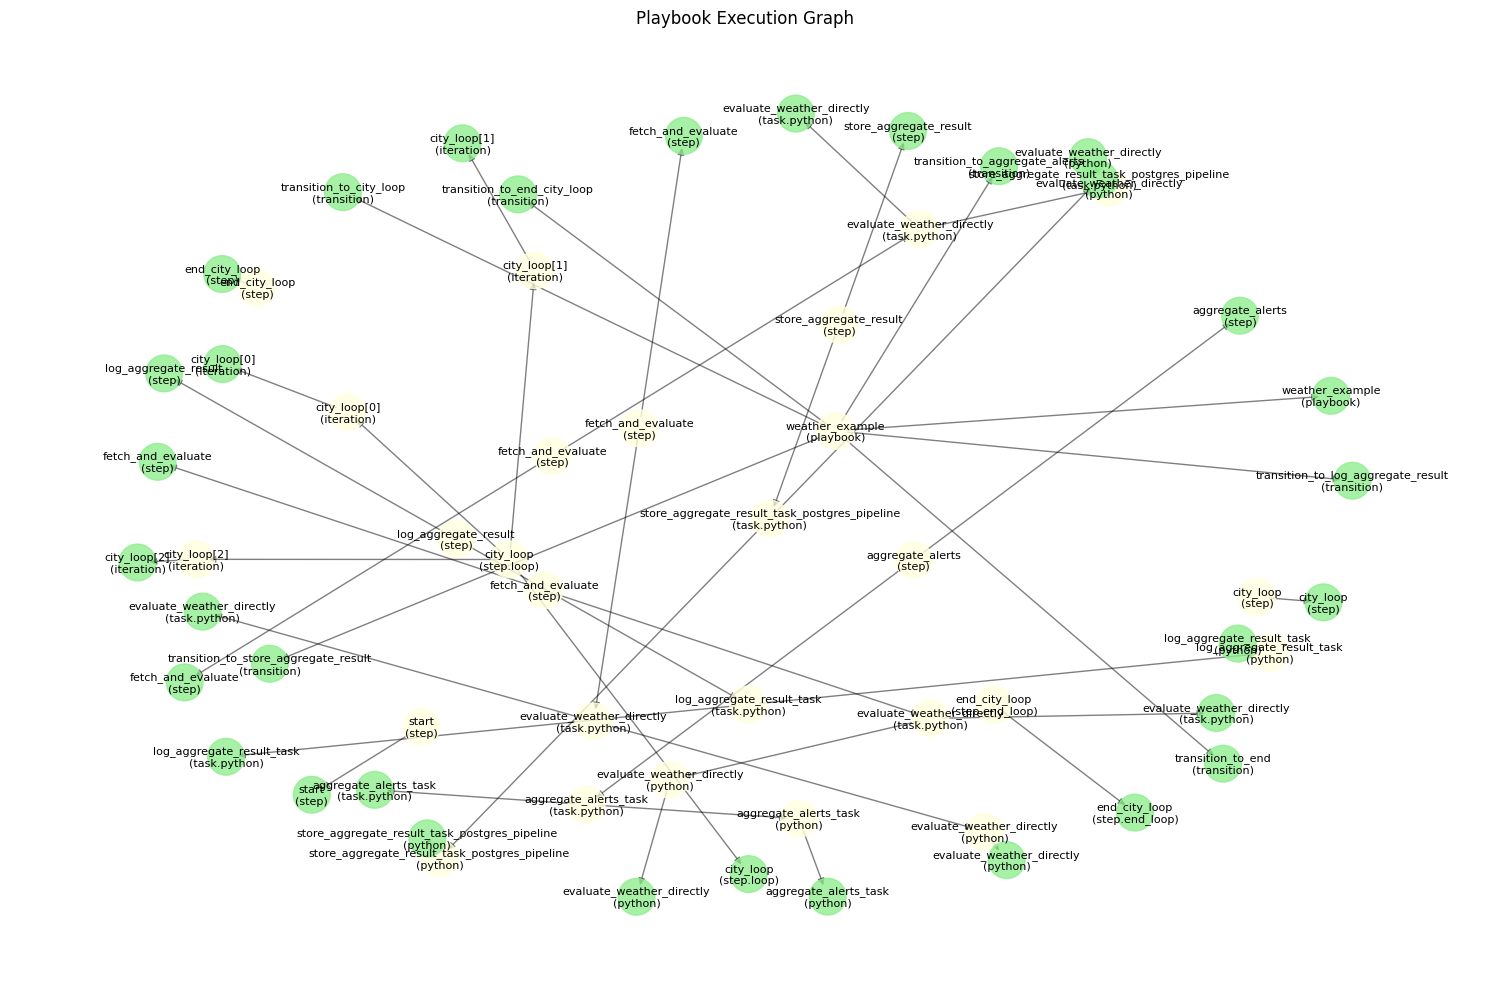

In [63]:
if execution_id:
    graph_data = con.execute("""
        SELECT 
            event_id, 
            parent_event_id, 
            node_id, 
            node_name, 
            node_type, 
            event_type, 
            status
        FROM event_log
        WHERE execution_id = ?
        ORDER BY timestamp
    """, [execution_id]).fetchall()

    G = nx.DiGraph()
    node_colors = []
    node_labels = {}

    for event in graph_data:
        event_id, parent_event_id, node_id, node_name, node_type, event_type, status = event

        if not G.has_node(event_id):
            G.add_node(event_id)
            node_labels[event_id] = f"{node_name}\n({node_type})"

            if status == 'success':
                node_colors.append('lightgreen')
            elif status == 'error':
                node_colors.append('lightcoral')
            elif status == 'in_progress':
                node_colors.append('lightyellow')
            else:
                node_colors.append('lightblue')

        if parent_event_id and G.has_node(parent_event_id):
            G.add_edge(parent_event_id, event_id)
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, arrows=True)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    plt.title("Playbook Execution Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No execution ID available for graph visualization.")


## Workflow Block Schema Visualization

The execution flow as a block schema, highlighting sequential steps and forks in the workflow.


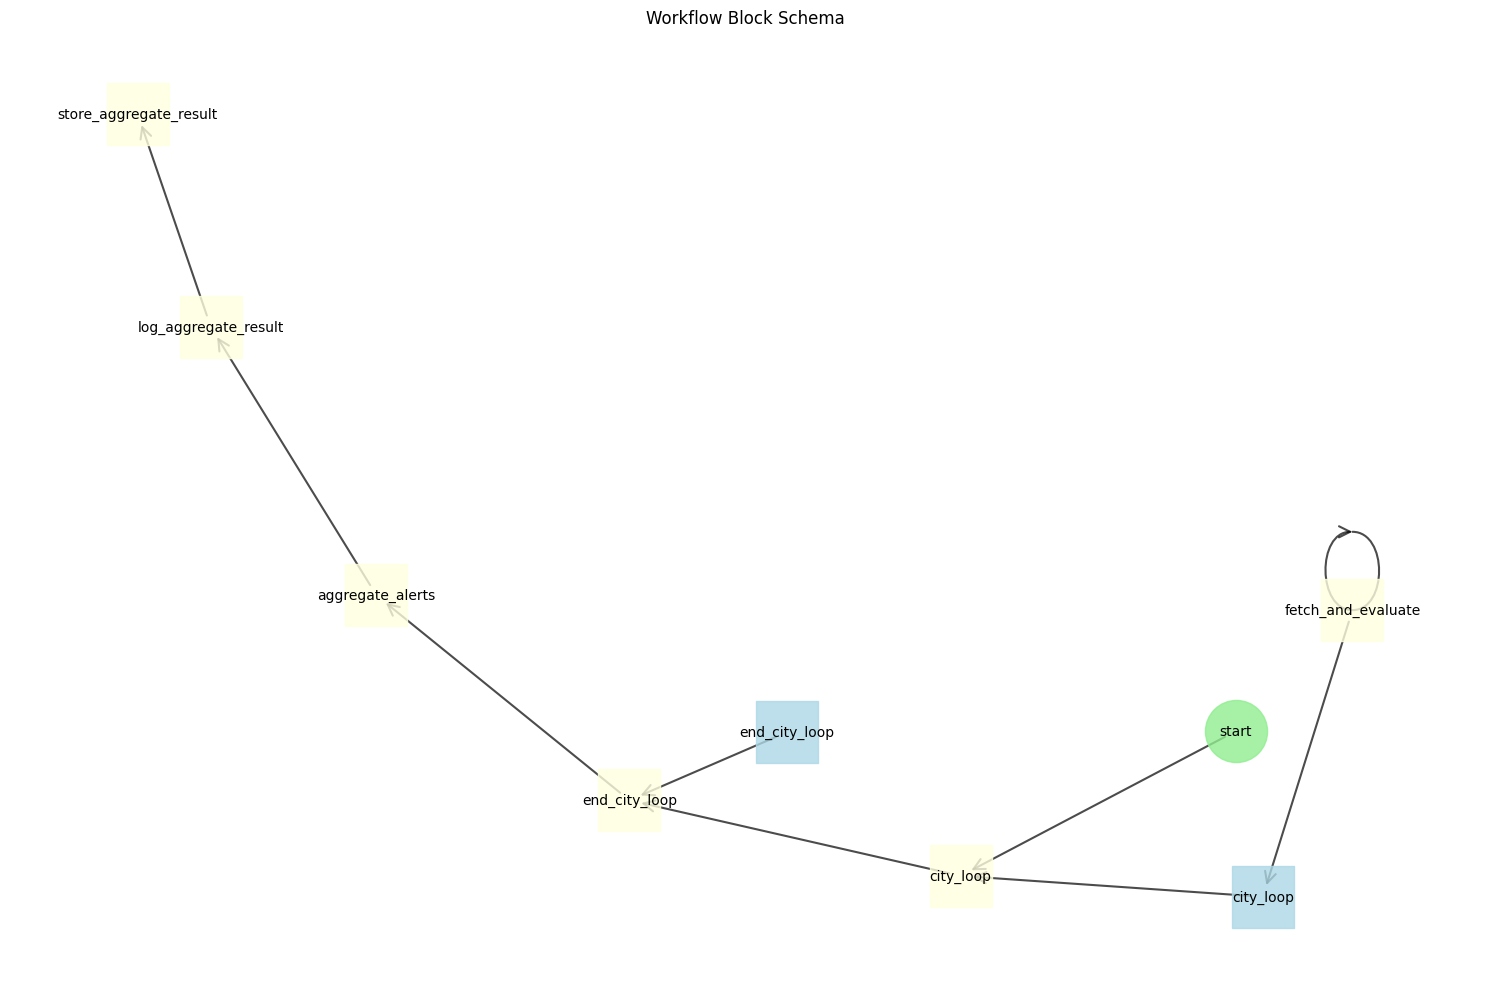

Workflow contains 9 unique steps and 9 transitions
Sequential steps: 7
Fork points: 1
Fork points (steps with multiple outgoing transitions):
  - fetch_and_evaluate (2 branches)


In [64]:
if execution_id:
    workflow_data = con.execute("""
        SELECT 
            event_id, 
            parent_event_id, 
            node_id, 
            node_name, 
            node_type, 
            event_type, 
            status,
            metadata
        FROM event_log
        WHERE execution_id = ? AND node_type IN ('step', 'step.loop', 'step.end_loop')
        ORDER BY timestamp
    """, [execution_id]).fetchall()

    WG = nx.DiGraph()
    node_by_name = {}
    for event in workflow_data:
        event_id, parent_event_id, node_id, node_name, node_type, event_type, status, metadata = event
        if 'error' in event_type or event_type in ['execution_start', 'execution_complete']:
            continue
        node_key = f"{node_name}_{node_type}"
        if node_key not in node_by_name:
            node_by_name[node_key] = node_key

            if 'loop' in node_type:
                node_shape = 'box'
                node_color = 'lightblue'
            elif node_name in ['start', 'end']:
                node_shape = 'oval'
                node_color = 'lightgreen' if node_name == 'start' else 'lightcoral'
            else:
                node_shape = 'box'
                node_color = 'lightyellow'
            WG.add_node(node_key, label=node_name, shape=node_shape, color=node_color, type=node_type)

    step_transitions = {}

    for i in range(len(workflow_data) - 1):
        current = workflow_data[i]
        next_event = workflow_data[i + 1]

        current_name = current[3]  # node_name
        current_type = current[4]  # node_type
        current_event_type = current[5]  # event_type

        next_name = next_event[3]  # node_name
        next_type = next_event[4]  # node_type

        if 'start' in current_event_type or 'error' in current_event_type:
            continue

        current_key = f"{current_name}_{current_type}"
        next_key = f"{next_name}_{next_type}"

        if current_key in node_by_name and next_key in node_by_name:
            transition_key = f"{current_key}_{next_key}"
            if transition_key not in step_transitions:
                step_transitions[transition_key] = True
                WG.add_edge(current_key, next_key)

    plt.figure(figsize=(15, 10))

    try:
        import pygraphviz
        pos = nx.nx_agraph.graphviz_layout(WG, prog='dot', args='-Grankdir=TB')
    except (ImportError, AttributeError):
        try:
            import pydot
            pos = nx.drawing.nx_pydot.pydot_layout(WG, prog='dot')
        except (ImportError, AttributeError):
            pos = nx.spring_layout(WG, seed=42)

    for node, attrs in WG.nodes(data=True):
        shape = attrs.get('shape', 'box')
        color = attrs.get('color', 'lightgray')
        label = attrs.get('label', node)

        if shape == 'box':
            nx.draw_networkx_nodes(WG, pos, nodelist=[node], node_color=color, node_shape='s', node_size=2000, alpha=0.8)
        elif shape == 'oval':
            nx.draw_networkx_nodes(WG, pos, nodelist=[node], node_color=color, node_shape='o', node_size=2000, alpha=0.8)

        x, y = pos[node]
        plt.text(x, y, label, fontsize=10, ha='center', va='center')

    nx.draw_networkx_edges(WG, pos, width=1.5, alpha=0.7, arrowsize=20, arrowstyle='->')

    plt.title("Workflow Block Schema")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"Workflow contains {WG.number_of_nodes()} unique steps and {WG.number_of_edges()} transitions")

    sequential_nodes = []
    fork_nodes = []

    for node in WG.nodes():
        out_degree = WG.out_degree(node)
        if out_degree > 1:
            fork_nodes.append(node)
        elif out_degree == 1:
            sequential_nodes.append(node)

    print(f"Sequential steps: {len(sequential_nodes)}")
    print(f"Fork points: {len(fork_nodes)}")
    if fork_nodes:
        print("Fork points (steps with multiple outgoing transitions):")
        for node in fork_nodes:
            print(f"  - {WG.nodes[node]['label']} ({WG.out_degree(node)} branches)")
else:
    print("No execution ID for workflow visualization.")


## Preview `event_log` table


In [65]:
table_name = 'event_log'
event_log_df = pl.from_arrow(con.execute(f"SELECT * FROM {table_name} LIMIT 100").arrow())
event_log_df


execution_id,event_id,parent_event_id,timestamp,event_type,node_id,node_name,node_type,status,duration,input_context,output_result,metadata
str,str,str,datetime[μs],str,str,str,str,str,f64,str,str,str
"""e1fe532e-5719-4fae-b4fe-afea46…","""3a180eac-e7f1-4abd-9f93-11749b…",null,2025-06-18 06:42:22.774743,"""execution_start""","""e1fe532e-5719-4fae-b4fe-afea46…","""weather_example""","""playbook""","""in_progress""",0.0,"""{""jobId"": ""{{ job.uuid }}"", ""s…",null,"""{""playbook_path"": ""./catalog/p…"
"""e1fe532e-5719-4fae-b4fe-afea46…","""58257fb5-800b-4dab-80af-27080a…",null,2025-06-18 06:42:22.776071,"""step_start""","""057dfb2d-fdf0-4f98-9a89-89b1ef…","""start""","""step""","""in_progress""",0.0,"""{""jobId"": ""{{ job.uuid }}"", ""s…",null,"""{""step_type"": ""standard""}"""
"""e1fe532e-5719-4fae-b4fe-afea46…","""dc6dfe6e-9bbd-433c-928d-69a29d…","""58257fb5-800b-4dab-80af-27080a…",2025-06-18 06:42:22.776920,"""step_complete""","""057dfb2d-fdf0-4f98-9a89-89b1ef…","""start""","""step""","""success""",0.001031,"""{""jobId"": ""{{ job.uuid }}"", ""s…","""{}""","""{""step_type"": ""standard""}"""
"""e1fe532e-5719-4fae-b4fe-afea46…","""58e5c019-0e29-4212-abea-0655bc…","""3a180eac-e7f1-4abd-9f93-11749b…",2025-06-18 06:42:22.779603,"""step_transition""","""e1fe532e-5719-4fae-b4fe-afea46…","""transition_to_city_loop""","""transition""","""success""",0.0,"""{""jobId"": ""{{ job.uuid }}"", ""s…",null,"""{""from_step"": ""start"", ""to_ste…"
"""e1fe532e-5719-4fae-b4fe-afea46…","""879d8fcd-5a2e-432c-a593-b8c2ab…",null,2025-06-18 06:42:22.780352,"""step_start""","""b5e28afb-5588-425b-a973-acda2f…","""city_loop""","""step""","""in_progress""",0.0,"""{""jobId"": ""{{ job.uuid }}"", ""s…",null,"""{""step_type"": ""standard""}"""
…,…,…,…,…,…,…,…,…,…,…,…,…
"""e1fe532e-5719-4fae-b4fe-afea46…","""33c25a07-5a32-4052-ae84-0ae9c1…","""f8bbf599-26bd-45fc-a47f-daeda9…",2025-06-18 06:42:25.166758,"""task_complete""","""825cf83d-ff95-4a54-b1a8-dc7e54…","""store_aggregate_result_task_po…","""python""","""success""",0.130938,"""{""jobId"": ""{{ job.uuid }}"", ""s…","""{""status"": ""stored_in_postgres…","""{""with_params"": {""summary"": {""…"
"""e1fe532e-5719-4fae-b4fe-afea46…","""15a51b90-af41-4a6c-b482-e3f690…","""f602483d-f495-49b9-9344-0a9ffc…",2025-06-18 06:42:25.167386,"""task_complete""","""347ef841-426b-4662-bd33-63f3b0…","""store_aggregate_result_task_po…","""task.python""","""success""",0.132192,"""{""jobId"": ""{{ job.uuid }}"", ""s…","""{""status"": ""stored_in_postgres…","""{""task_type"": ""python""}"""
"""e1fe532e-5719-4fae-b4fe-afea46…","""5d355268-6991-4e58-ae67-9f3586…","""4cfce6d1-4fc0-45c4-96a4-da16f0…",2025-06-18 06:42:25.169683,"""step_complete""","""ab69fefa-e1d0-45ed-9723-9d60b7…","""store_aggregate_result""","""step""","""success""",0.135826,"""{""jobId"": ""{{ job.uuid }}"", ""s…","""{""status"": ""stored_in_postgres…","""{""step_type"": ""standard""}"""


## Step Results

The step results from the playbook execution.


In [66]:
step_results_df = pl.from_arrow(con.execute("SELECT * FROM step_result ORDER BY timestamp DESC LIMIT 10").arrow())
step_results_df = parse_json_column(step_results_df, 'data')
step_results_df


execution_id,step_id,step_name,parent_id,timestamp,status,data,error
str,str,str,str,datetime[μs],str,object,str
"""e1fe532e-5719-4fae-b4fe-afea46…","""d403e6ca-ba5d-4c88-b71d-f3f4ae…","""end_city_loop""","""fb6f2120-d170-4d5a-9633-158177…",2025-06-18 06:42:25.016267,"""success""","{'alerts': ""[{'city': 'London', 'max_temp': 27.7, 'alert': True}, {'city': 'Paris', 'max_temp': 29.0, 'alert': True}, {'city': 'Berlin', 'max_temp': 26.8, 'alert': True}]""}",null
"""e1fe532e-5719-4fae-b4fe-afea46…","""b5e28afb-5588-425b-a973-acda2f…","""city_loop""",null,2025-06-18 06:42:24.992813,"""success""","[{'fetch_and_evaluate': {'city': 'London', 'max_temp': 27.7, 'alert': True}}, {'fetch_and_evaluate': {'city': 'Paris', 'max_temp': 29.0, 'alert': True}}, {'fetch_and_evaluate': {'city': 'Berlin', 'max_temp': 26.8, 'alert': True}}]",null
"""e1fe532e-5719-4fae-b4fe-afea46…","""057dfb2d-fdf0-4f98-9a89-89b1ef…","""start""",null,2025-06-18 06:42:22.776563,"""success""",{},null


## Task Results

The recent task results from the playbook execution.


In [67]:
task_results_df = pl.from_arrow(con.execute("""
    SELECT 
        node_id as task_id, 
        node_name as task_name, 
        node_type as task_type, 
        parent_event_id as parent_id, 
        timestamp, 
        status, 
        output_result as data, 
        CASE WHEN status = 'error' THEN metadata ELSE NULL END as error
    FROM event_log
    WHERE node_type LIKE 'task.%'
    ORDER BY timestamp DESC 
    LIMIT 10
""").arrow())
task_results_df = parse_json_column(task_results_df, 'data')
task_results_df


execution_id,task_id,task_name,task_type,parent_id,timestamp,status,data,error
str,str,str,str,str,datetime[μs],str,object,str
"""e1fe532e-5719-4fae-b4fe-afea46…","""825cf83d-ff95-4a54-b1a8-dc7e54…","""store_aggregate_result_task_po…","""python""","""f602483d-f495-49b9-9344-0a9ffc…",2025-06-18 06:42:25.165850,"""success""","{'status': 'stored_in_postgres', 'summary': {'alert_cities': ['London', 'Paris', 'Berlin'], 'count': 3}}",null
"""e1fe532e-5719-4fae-b4fe-afea46…","""2c0461b3-e131-4681-80e1-0b5374…","""log_aggregate_result_task""","""python""","""80268476-aab7-4f6d-97bf-c29c6d…",2025-06-18 06:42:25.029853,"""success""","{'logged': True, 'summary': {'alert_cities': ['London', 'Paris', 'Berlin'], 'count': 3}}",null
"""e1fe532e-5719-4fae-b4fe-afea46…","""b04b8e1d-056c-4fbc-9181-340e9e…","""aggregate_alerts_task""","""python""","""a60c6f4c-b1b1-49d5-9e56-9440d9…",2025-06-18 06:42:25.023462,"""success""","{'global_alert': True, 'summary': {'alert_cities': ['London', 'Paris', 'Berlin'], 'count': 3}}",null
"""e1fe532e-5719-4fae-b4fe-afea46…","""eba2ad41-6549-43b4-b786-6f2c14…","""evaluate_weather_directly""","""python""","""611e0697-43ea-44ac-9109-9e8f24…",2025-06-18 06:42:24.980871,"""success""","{'city': 'Berlin', 'max_temp': 26.8, 'alert': True}",null
"""e1fe532e-5719-4fae-b4fe-afea46…","""72874305-efbc-412a-b6be-736e89…","""evaluate_weather_directly""","""python""","""e4bb4ff1-55a3-471a-9f34-08b411…",2025-06-18 06:42:24.278250,"""success""","{'city': 'Paris', 'max_temp': 29.0, 'alert': True}",null
"""e1fe532e-5719-4fae-b4fe-afea46…","""71f9280e-8977-4153-819f-34cbc5…","""evaluate_weather_directly""","""python""","""848a8ca4-2d7f-4443-ac20-5ab1f6…",2025-06-18 06:42:23.583151,"""success""","{'city': 'London', 'max_temp': 27.7, 'alert': True}",null


## Postgres Results

Results stored in the Postgres database.


Weather Alert Summary from Postgres:


,id,alert_cities,alert_count,created_at
0,1750738666709,"[""London"", ""Paris"", ""Berlin""]",3,2025-06-23 23:17:46.740114


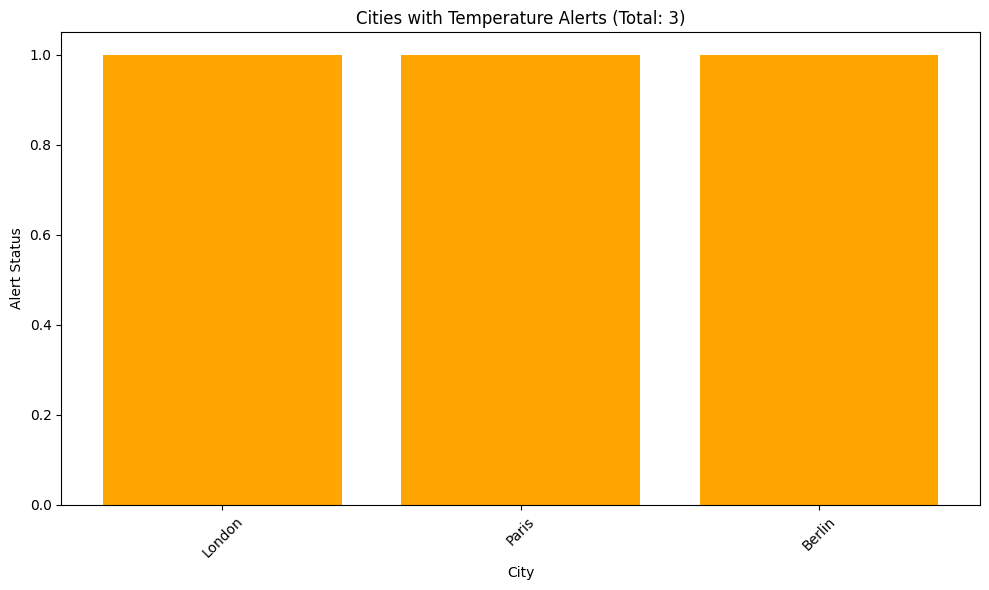

In [68]:
try:
    con.execute("INSTALL postgres;")
    con.execute("LOAD postgres;")
    attached_dbs = con.execute("SHOW DATABASES").fetchall()
    postgres_db_attached = any(db[0] == 'postgres_db' for db in attached_dbs)
    if not postgres_db_attached:
        con.execute("ATTACH 'dbname=noetl user=noetl password=noetl host=localhost port=5434' AS postgres_db (TYPE postgres);")
    postgres_results = con.execute("""
        SELECT * FROM postgres_db.weather_alert_summary
        ORDER BY created_at DESC
        LIMIT 10
    """).fetchdf()

    print("Weather Alert Summary from Postgres:")
    display(postgres_results)

    if not postgres_results.empty:
        plt.figure(figsize=(10, 6))

        def parse_cities(cities_json):
            try:
                return json.loads(cities_json)
            except:
                return []

        latest_record = postgres_results.iloc[0]
        cities = parse_cities(latest_record['alert_cities'])

        if cities:
            plt.bar(cities, [1] * len(cities), color='orange')
            plt.title(f"Cities with Temperature Alerts (Total: {latest_record['alert_count']})")
            plt.xlabel("City")
            plt.ylabel("Alert Status")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print("No cities with alerts found in the latest record.")
    else:
        print("No data found in the weather_alert_summary table.")

except Exception as e:
    print(f"Error connecting to Postgres: {e}")
    print("Make sure the Postgres database is running and accessible.")


## SQL Query Interface

SQL interface for querying the DuckDB database.


In [69]:
%reload_ext sql
%sql con --alias duckdb
%sql SELECT node_id as task_id, node_name as task_name, node_type as task_type, parent_event_id as parent_id, timestamp, status, output_result as data, CASE WHEN status = 'error' THEN metadata ELSE NULL END as error FROM event_log WHERE node_type LIKE 'task.%' ORDER BY timestamp DESC LIMIT 1


The 'toml' package isn't installed. To load settings from pyproject.toml or ~/.jupysql/config, install with: pip install toml

Running query in 'duckdb'

execution_id,task_id,task_name,task_type,parent_id,timestamp,status,data,error
e1fe532e-5719-4fae-b4fe-afea46c06d29,825cf83d-ff95-4a54-b1a8-dc7e5402b320,store_aggregate_result_task_postgres_pipeline,python,f602483d-f495-49b9-9344-0a9ffcb45576,2025-06-18 06:42:25.165850,success,"{""status"": ""stored_in_postgres"", ""summary"": {""alert_cities"": [""London"", ""Paris"", ""Berlin""], ""count"": 3}}",None


In [70]:
%sql SELECT * FROM event_log LIMIT 1


Running query in 'duckdb'

execution_id,event_id,parent_event_id,timestamp,event_type,node_id,node_name,node_type,status,duration,input_context,output_result,metadata
e1fe532e-5719-4fae-b4fe-afea46c06d29,3a180eac-e7f1-4abd-9f93-11749b3340a9,None,2025-06-18 06:42:22.774743,execution_start,e1fe532e-5719-4fae-b4fe-afea46c06d29,weather_example,playbook,in_progress,0.0,"{""jobId"": ""{{ job.uuid }}"", ""state"": ""ready"", ""cities"": [{""name"": ""London"", ""lat"": 51.51, ""lon"": -0.13}, {""name"": ""Paris"", ""lat"": 48.85, ""lon"": 2.35}, {""name"": ""Berlin"", ""lat"": 52.52, ""lon"": 13.41}], ""base_url"": ""https://api.open-meteo.com/v1"", ""temperature_threshold"": 26, ""workload"": {""jobId"": ""{{ job.uuid }}"", ""state"": ""ready"", ""cities"": [{""name"": ""London"", ""lat"": 51.51, ""lon"": -0.13}, {""name"": ""Paris"", ""lat"": 48.85, ""lon"": 2.35}, {""name"": ""Berlin"", ""lat"": 52.52, ""lon"": 13.41}], ""base_url"": ""https://api.open-meteo.com/v1"", ""temperature_threshold"": 26}, ""execution_start"": ""2025-06-18T06:42:22.774386""}",None,"{""playbook_path"": ""./catalog/playbooks/weather_example.yaml""}"


## Execution Summary

Summary of the playbook execution, including key metrics and findings.


## Playbook Execution Summary
Total Steps: 3
Successful Steps: 3
Step Success Rate: 100.00%

Total Tasks: 6
Successful Tasks: 6
Task Success Rate: 100.00%

## Weather Alert Summary
Alert Cities: London, Paris, Berlin
Alert Count: 3


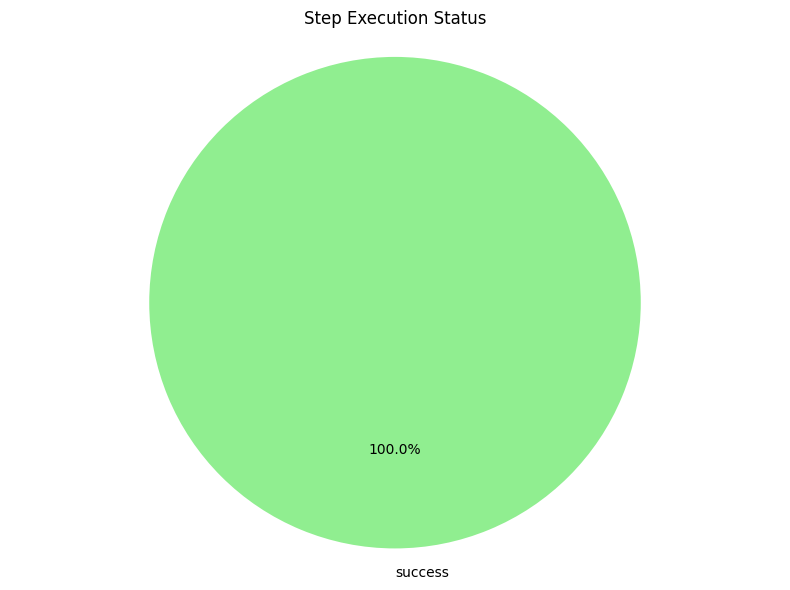

In [71]:
if execution_id:
    summary_data = {}

    step_stats = con.execute("""
        SELECT 
            COUNT(*) as total_steps,
            COUNT(CASE WHEN status = 'success' THEN 1 END) as successful_steps,
            CAST(COUNT(CASE WHEN status = 'success' THEN 1 END) AS FLOAT) / COUNT(*) * 100 as success_rate
        FROM step_result
        WHERE execution_id = ?
    """, [execution_id]).fetchone()

    summary_data['step_stats'] = {
        'total': step_stats[0],
        'successful': step_stats[1],
        'success_rate': step_stats[2]
    }

    task_stats = con.execute("""
        SELECT 
            COUNT(*) as total_tasks,
            COUNT(CASE WHEN status = 'success' THEN 1 END) as successful_tasks,
            CAST(COUNT(CASE WHEN status = 'success' THEN 1 END) AS FLOAT) / COUNT(*) * 100 as success_rate
        FROM event_log
        WHERE execution_id = ? AND node_type LIKE 'task.%'
    """, [execution_id]).fetchone()

    summary_data['task_stats'] = {
        'total': task_stats[0],
        'successful': task_stats[1],
        'success_rate': task_stats[2]
    }

    try:
        weather_summary = con.execute("""
            SELECT output_result as data
            FROM event_log
            WHERE execution_id = ? AND task_name = 'aggregate_alerts_task'
            ORDER BY timestamp DESC
            LIMIT 1
        """, [execution_id]).fetchone()

        if weather_summary and weather_summary[0]:
            summary_data['weather_summary'] = json.loads(weather_summary[0])
    except:
        pass

    print("## Playbook Execution Summary")
    print(f"Total Steps: {summary_data['step_stats']['total']}")
    print(f"Successful Steps: {summary_data['step_stats']['successful']}")
    print(f"Step Success Rate: {summary_data['step_stats']['success_rate']:.2f}%")
    print()
    print(f"Total Tasks: {summary_data['task_stats']['total']}")
    print(f"Successful Tasks: {summary_data['task_stats']['successful']}")
    print(f"Task Success Rate: {summary_data['task_stats']['success_rate']:.2f}%")
    print()

    if 'weather_summary' in summary_data:
        print("## Weather Alert Summary")
        if 'summary' in summary_data['weather_summary']:
            summary = summary_data['weather_summary']['summary']
            print(f"Alert Cities: {', '.join(summary.get('alert_cities', []))}")
            print(f"Alert Count: {summary.get('count', 0)}")
        else:
            print("No weather alert summary found.")

    step_status_counts = con.execute("""
        SELECT 
            status,
            COUNT(*) as count
        FROM step_result
        WHERE execution_id = ?
        GROUP BY status
    """, [execution_id]).fetchall()

    if step_status_counts:
        plt.figure(figsize=(8, 6))
        labels = [status[0] for status in step_status_counts]
        sizes = [status[1] for status in step_status_counts]
        colors = ['lightgreen' if label == 'success' else 'lightcoral' if label == 'error' else 'lightyellow' for label in labels]

        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.axis('equal')
        plt.title('Step Execution Status')
        plt.tight_layout()
        plt.show()
else:
    print("No execution ID for summary.")
